In [1]:
#import
import os
import numpy as np
import pandas as pd
import re
import itertools
from collections import Counter
import pickle
import jieba
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from pprint import pprint

In [2]:
#--reading the texts files
le_chemin = 'cleaned_articles'  # write the texts folder path

filenames = os.listdir(le_chemin)

lst = []

for filename in sorted(os.listdir(le_chemin)):  # for all file names in folder cleaned_articles
    #ignore hidden files
    if filename[0] != '.':

        file_path = os.path.join(le_chemin, filename)  # Create path with folder path and file names
        #x = file_path[17:-4]
        x = int(filename[:-4]) #we want the filename/id as int and not string
        boite = []
        with open(file_path, 'r') as f2:
            data = f2.read() #take the text in the file
       
        boite.append(x)
        boite.append(data)
        
        lst.append(boite)

Making a dataframe out of our list of list and renaming the dataframe columns. (we do not want to set the id column as index because some files are missing)

In [3]:
df_texts = pd.DataFrame(lst)
df_texts = df_texts.rename(columns = {0:'id',1:'texts'})
df_texts.head()

,id,texts
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1,10,武汉封城后的宠物营救计划人类犯错的后果不该由它们承担\n武汉封城后的宠物营救计划人类犯错的后...
2,100,黄冈一个武汉周边城市的疫情防控样本\n黄冈一个武汉周边城市的疫情防控样本黄冈一个武汉周边城市...
3,1000,超长相处期被父母逼疯的年轻人\n超长相处期被父母逼疯的年轻人超长相处期被父母逼疯的年轻人超长...
4,1001,武汉后临时外卖员我多跑一单就减少一个家庭感染的可能\n武汉后临时外卖员我多跑一单就减少一个家...


let's reorder the dataframe based on the id column and reset the index after re-ordering

In [4]:
df_texts = df_texts.sort_values(by = 'id' )
df_texts = df_texts.reset_index(drop=True)
df_texts.head()

,id,texts
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...
2,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...
3,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...
4,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...


We have a perfect dataframe. It is easy to display and the texts are easy to access individually or in group. We can save it just in case.

In [5]:
#create folder to save it:
if not os.path.exists('dataframe'):
    os.makedirs('dataframe')
    
df_texts.to_csv (r'dataframe/df_texts_without_index.csv', index = False, header=True) #save it without index if we want to open it with R
df_texts.to_csv (r'dataframe/df_texts_with_index.csv', index = True, header=True) #with index

The texts are already quite clean. We need to cut them with jieba. We start by loading our words with priority cutting into jieba before cutting. We do that because we want to remove the media names which comes back many times in the articles but do not provide more information on a topic. To be able to remove them from a stopword list, they must be cut properly first, hence the priority cutting.


In [7]:
with open('jieba_lists/UsrWords.txt', 'r', encoding='utf8') as f:
    custom_noun = f.readlines()
    for noun in custom_noun:
        jieba.add_word(noun.replace('\n', ''), freq=None, tag='n')

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.568 seconds.
Prefix dict has been built successfully.


cutting

In [8]:
df_texts['words'] = df_texts.texts.apply(jieba.lcut)
df_texts.head()

,id,texts,words
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,"[个, 临时, 发, 往, 武汉, 的, 口罩, \n, 个, 临时, 发, 往, 武汉, ..."
1,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...,"[武汉, 隔离, 疫区, 信息, 孤岛, 与, 一辆, 鄂车, 的, 漂流, \n, 武汉,..."
2,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...,"[我家, 离, 华南, 海鲜, 市场, 很近, 返乡, 封城, 过年, 一位, 武汉, 大学..."
3,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...,"[疫情, 危机, 中, 不, 被, 看见, 的, 人们, 武汉, 周边城市, 百姓, 的, ..."
4,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...,"[孝感, 前线, 医生, 武汉, 更难, 我们, 下面, 不好意思, 提, 要求, \n, ..."


Stopwords removal

In [9]:
fh = open("jieba_lists/stopwords.txt")
stopwords=[]
stopwords.append('\n') #append the '\n' in the beginning otherwise it would be erased by strip
stopwords.append('%')  #we append some special characters, I am also going to add it to the cleaning function pre-processing
stopwords.append('|')  #the texts but sometimes it does not catch them all
stopwords.append('△')
stopwords.append('▼')
stopwords.append('｜')
stopwords.append('\u3000') #this is a special empty space, I also removed tab space in the cleaning function, perhaps that'll help too
for line in fh:
    line = line.rstrip()
    stopwords.append(line)

def stp_removal(wordlist, stopwords=stopwords):
    lili=[]
    for word in wordlist:
        if word not in stopwords:
            lili.append(word)
    return lili

In [10]:
df_texts['cleaned_words'] = df_texts.words.apply(stp_removal)
df_texts.head()

,id,texts,words,cleaned_words
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,"[个, 临时, 发, 往, 武汉, 的, 口罩, \n, 个, 临时, 发, 往, 武汉, ...","[临时, 发, 武汉, 口罩, 临时, 发, 武汉, 口罩, 临时, 发, 武汉, 口罩, ..."
1,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...,"[武汉, 隔离, 疫区, 信息, 孤岛, 与, 一辆, 鄂车, 的, 漂流, \n, 武汉,...","[武汉, 隔离, 疫区, 信息, 孤岛, 一辆, 鄂车, 漂流, 武汉, 隔离, 疫区, 信..."
2,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...,"[我家, 离, 华南, 海鲜, 市场, 很近, 返乡, 封城, 过年, 一位, 武汉, 大学...","[我家, 华南, 海鲜, 市场, 很近, 返乡, 封城, 过年, 一位, 武汉, 大学生, ..."
3,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...,"[疫情, 危机, 中, 不, 被, 看见, 的, 人们, 武汉, 周边城市, 百姓, 的, ...","[疫情, 危机, 看见, 武汉, 周边城市, 百姓, 自救, 行动, 疫情, 危机, 看见,..."
4,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...,"[孝感, 前线, 医生, 武汉, 更难, 我们, 下面, 不好意思, 提, 要求, \n, ...","[孝感, 前线, 医生, 武汉, 更难, 下面, 不好意思, 提, 要求, 孝感, 前线, ..."


Prepare to LDA

In [11]:
data_lemmatized = df_texts.cleaned_words
#print(data_lemmatized)

id2word = gensim.corpora.Dictionary(data_lemmatized)

#Normally, it is better to filter most frequent words first. This time, however, we just want to see what comes
#out without doing it. We will use it in LDA2
#id2word.filter_extremes(no_above= 0.29) 

corpus = [id2word.doc2bow(doc) for doc in data_lemmatized]

Check what number of topic is best

In [13]:
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'/home/bilatli/DEV/mallet-2.0.8/'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'/home/bilatli/DEV/mallet-2.0.8/bin/mallet' 
#You should update this path as per the path of Mallet directory on your system.

def coherence_values_computation(dictionary, corpus, texts, limit, start=2, step=3):
   coherence_values = []
   model_list = []
   for num_topics in range(start, limit, step):
      model = gensim.models.wrappers.LdaMallet(
         mallet_path, corpus=corpus, num_topics=num_topics, iterations=1000, workers = 5, id2word=id2word
      )
      model_list.append(model)
      
      coherencemodel = CoherenceModel(
      model=model, texts=texts, dictionary=dictionary, coherence='c_v'
   )
      coherence_values.append(coherencemodel.get_coherence())
   return model_list, coherence_values

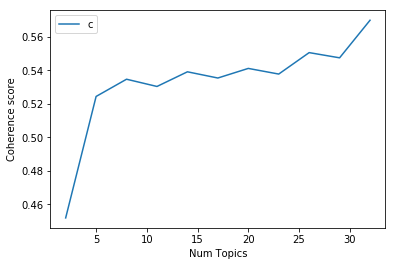

In [14]:
model_list, coherence_values = coherence_values_computation (
   dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
   start=2, limit=35, step=3
)

limit=35; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

let's check coherence value

In [15]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 2  is having Coherence Value of 0.452
Num Topics = 5  is having Coherence Value of 0.5244
Num Topics = 8  is having Coherence Value of 0.5347
Num Topics = 11  is having Coherence Value of 0.5304
Num Topics = 14  is having Coherence Value of 0.5391
Num Topics = 17  is having Coherence Value of 0.5354
Num Topics = 20  is having Coherence Value of 0.5412
Num Topics = 23  is having Coherence Value of 0.5378
Num Topics = 26  is having Coherence Value of 0.5506
Num Topics = 29  is having Coherence Value of 0.5475
Num Topics = 32  is having Coherence Value of 0.5699


Saving best model

In [16]:
optimal_model = model_list[2]

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)

vis = pyLDAvis.prepared_data_to_html(vis)

#create folder to save it:
if not os.path.exists('OUTPUT'):
    os.makedirs('OUTPUT')
    
with open("OUTPUT/1LDA_output11s-0.html", "w") as file:
    file.write(vis)

/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")
